In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
%matplotlib inline
from collections import Counter

import peakutils

from numpy.fft import fft, rfft, rfftfreq, irfft
import seaborn as sns

import pickle

from ipywidgets import FloatProgress
from IPython.display import display

from scipy import signal 

FD = 2000 # 2кГц - частота дискретизации сигнала

# Эксперименты

## Детки

In [2]:
files = [19, 20, 21, 24, 25, 28]
data = [pd.read_csv("../children/children_accepted_part/"+str(i)+".csv").sig1 for i in files]

rfft_data = []
for d in data:
    rfft_data.append(np.abs(rfft(d[0:524288]))/524288)

In [12]:
%timeit STFT_children2(data[2])

1 loops, best of 3: 43.2 s per loop


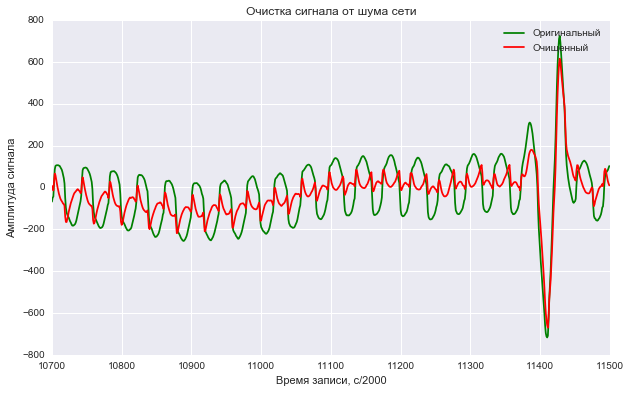

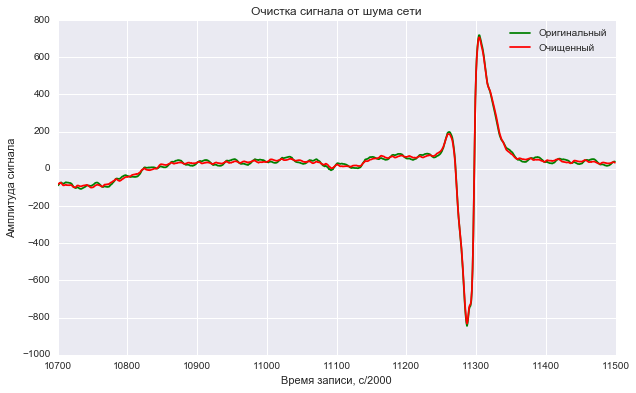

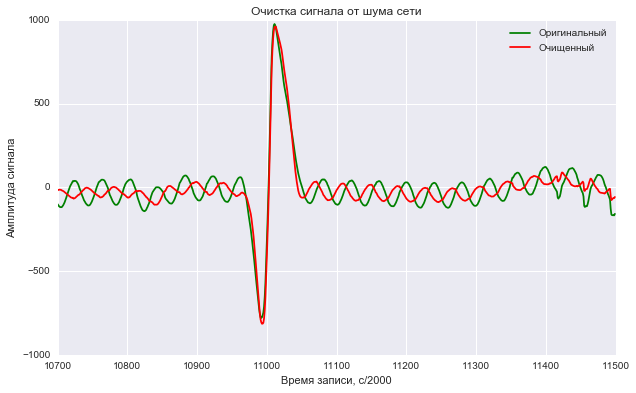

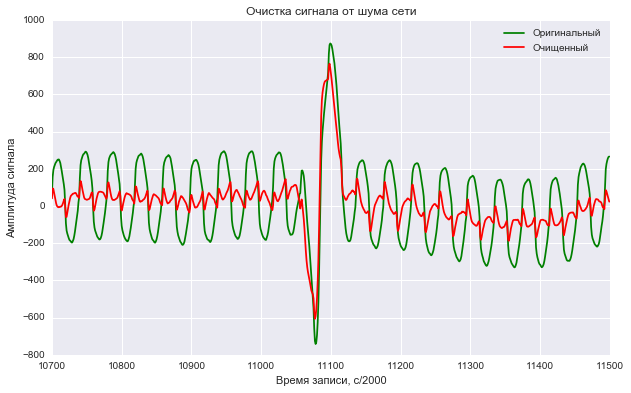

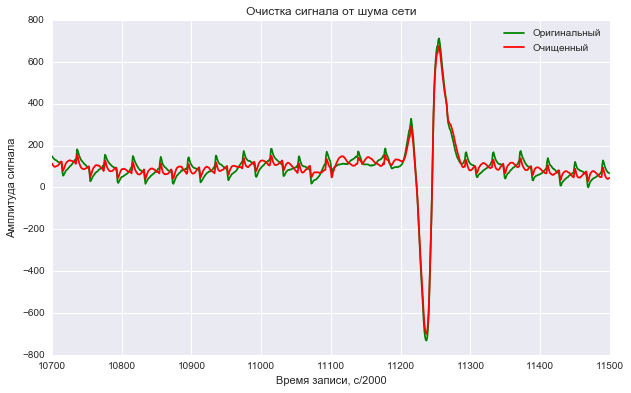

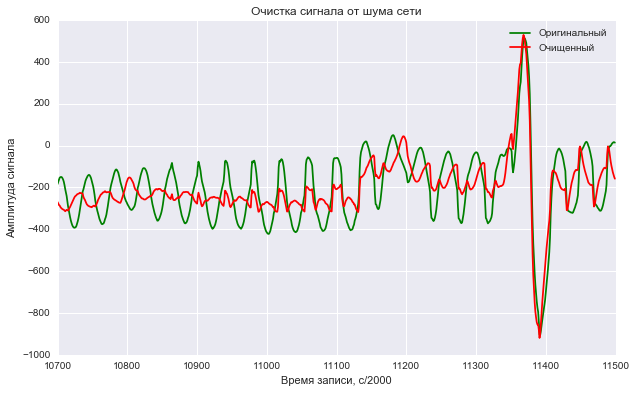

In [26]:
for i in range(len(data)):
    plt.figure(figsize=(10, 6))
    plt.plot(data[i][10700:11500], c='g', label=u'Оригинальный')
    plt.xlabel(u"Время записи, c/2000")
    plt.ylabel(u"Амплитуда сигнала")

    cleaned = STFT_children(data[i][:50000])[0]
    plt.title(u'Очистка сигнала от шума сети')
    plt.plot(cleaned[10700:11500], c='r', label=u'Очищенный')
    plt.legend()

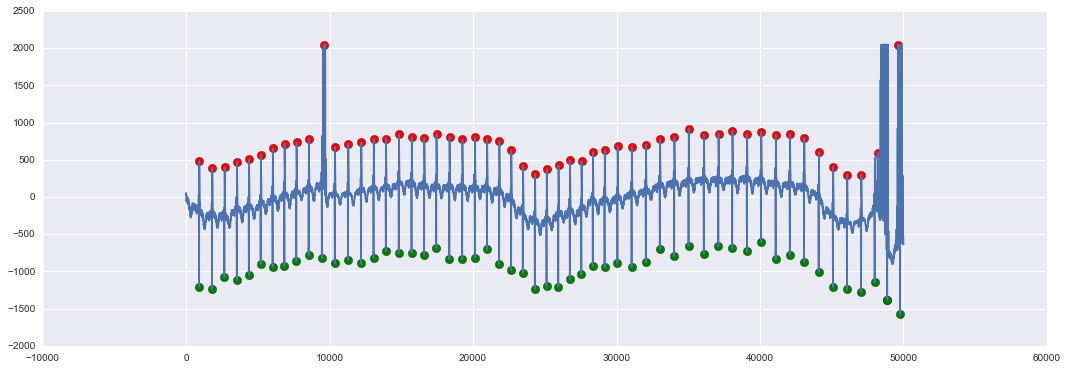

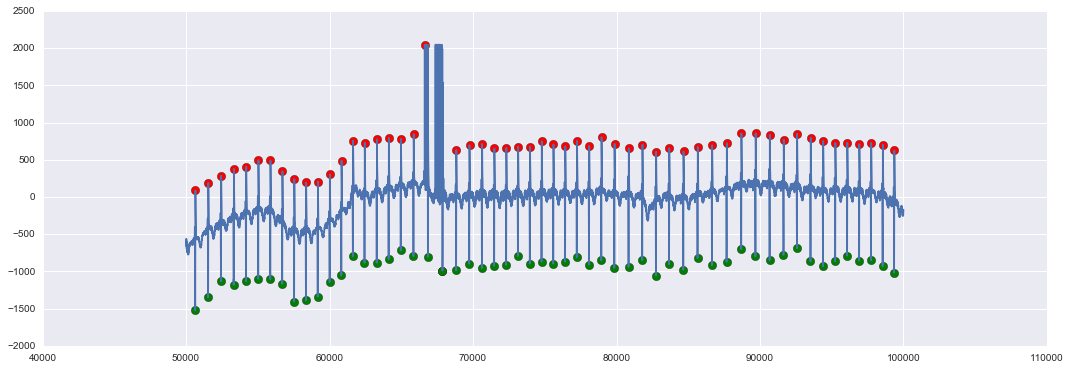

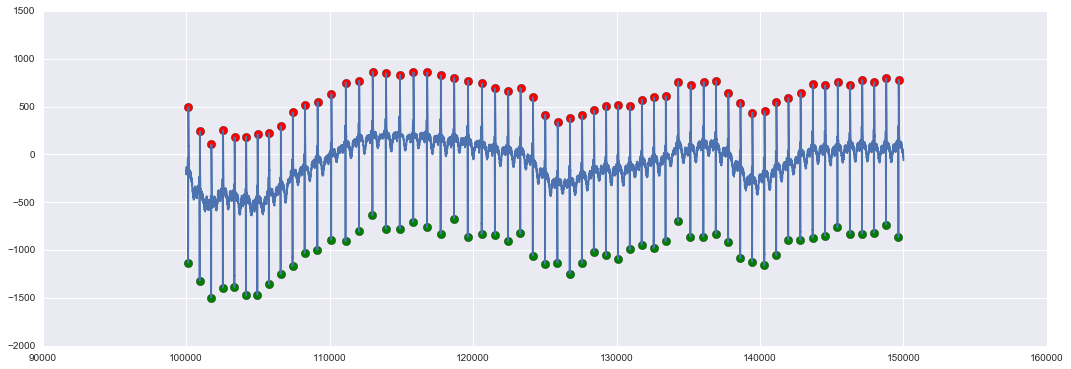

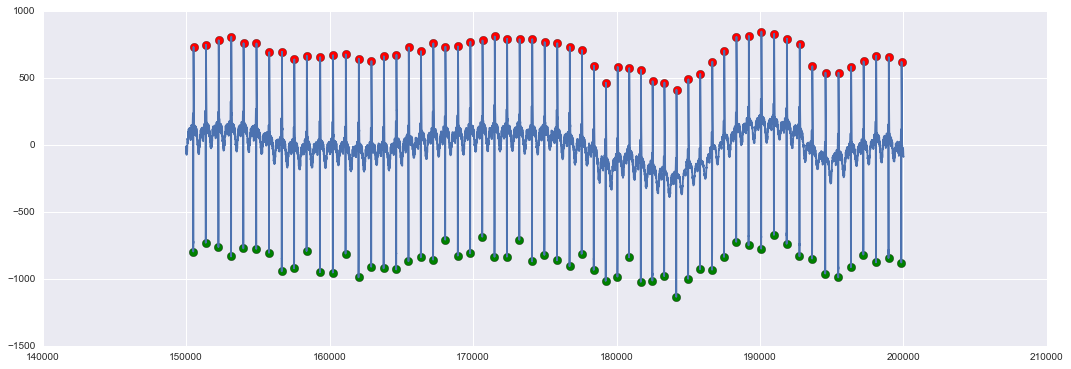

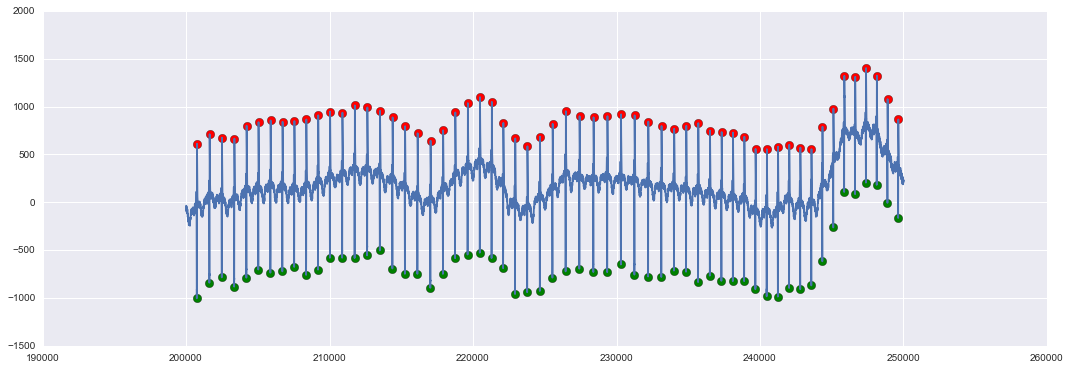

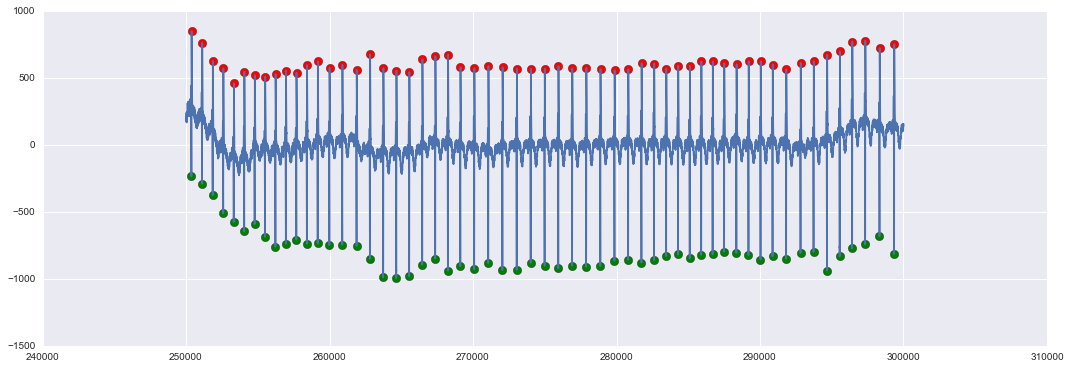

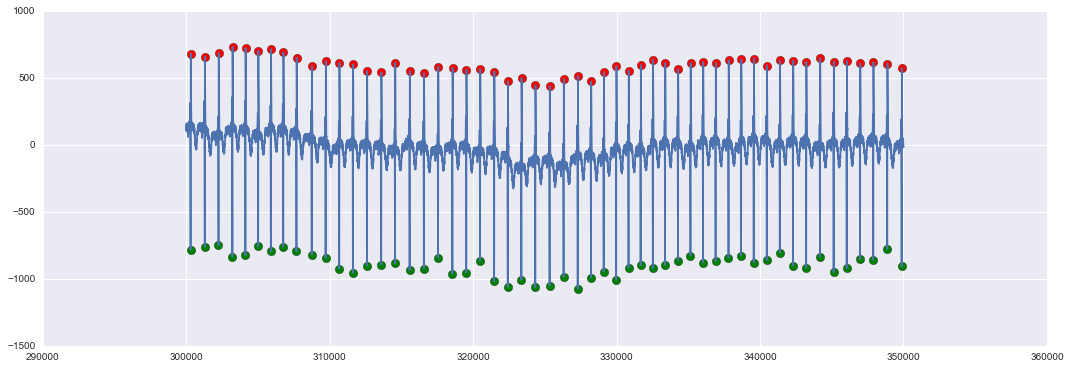

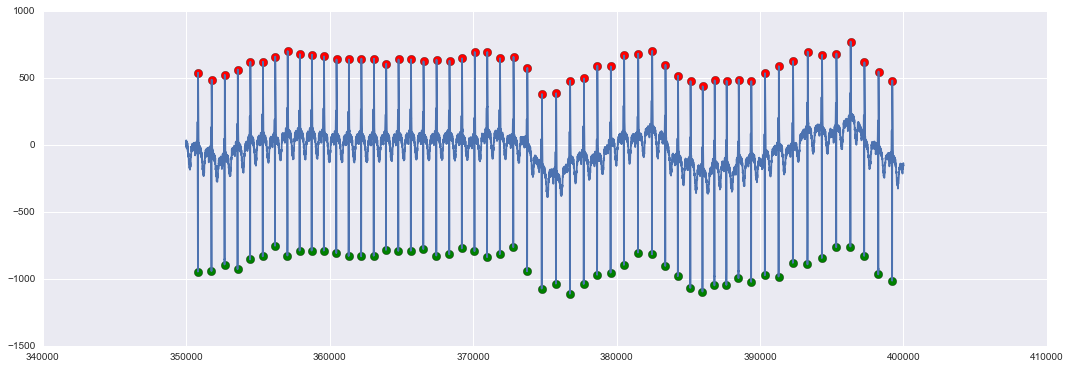

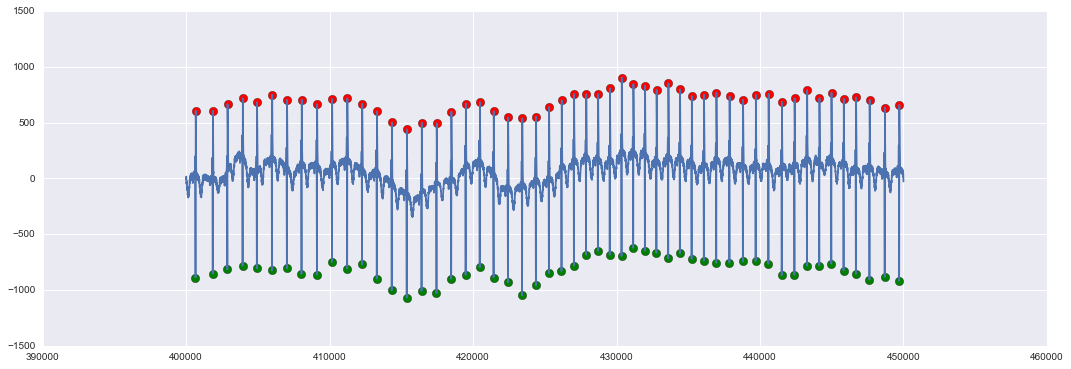

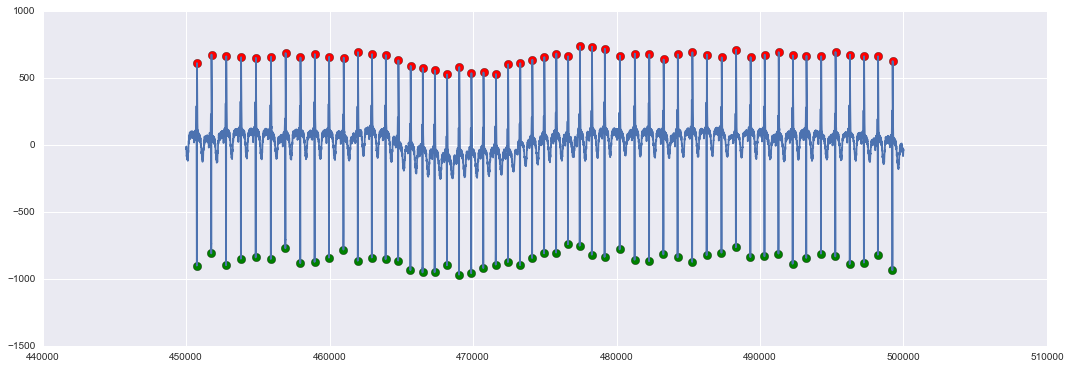

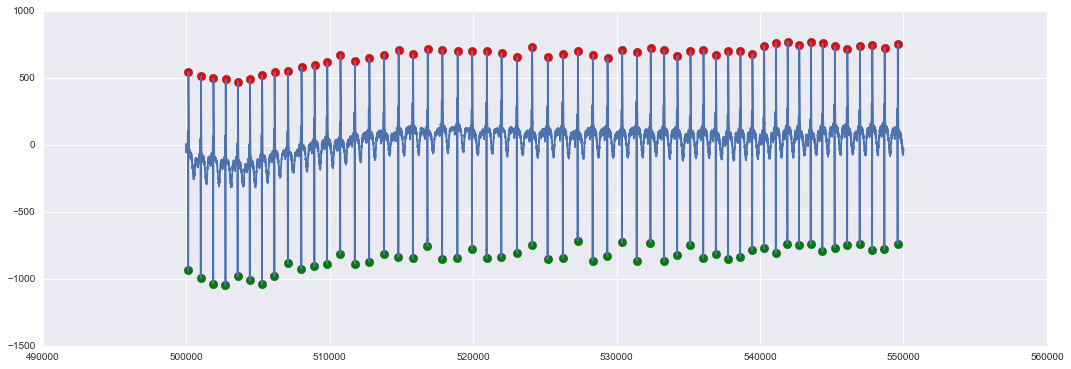

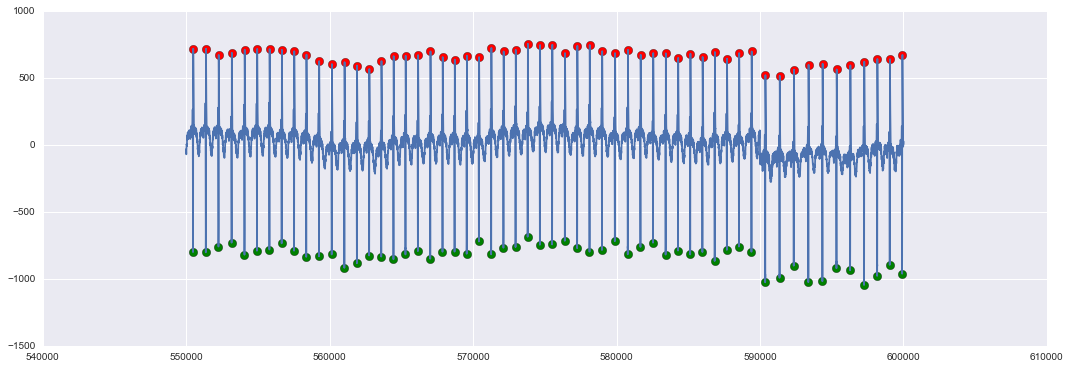

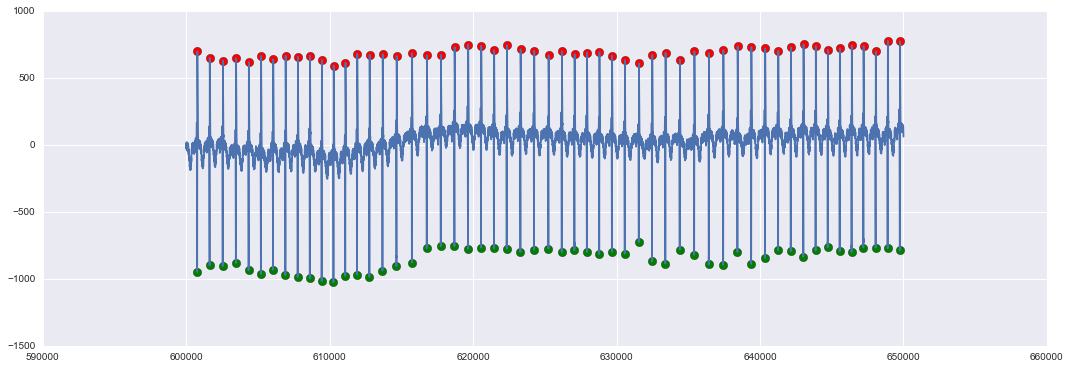

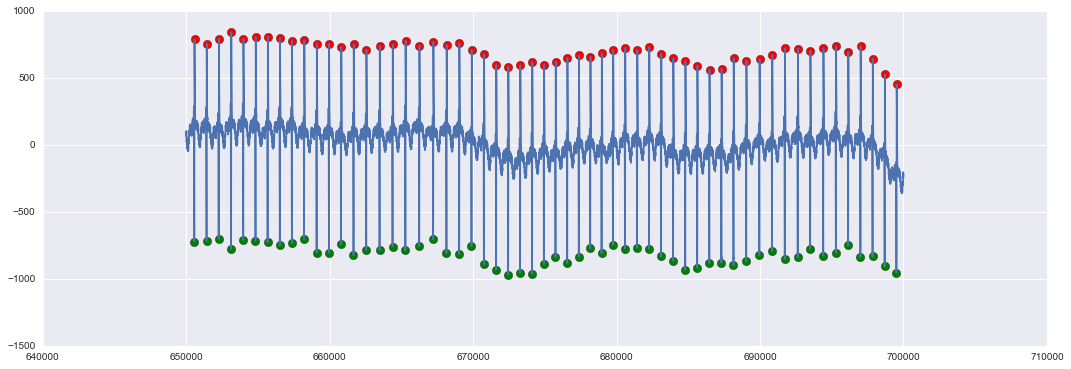

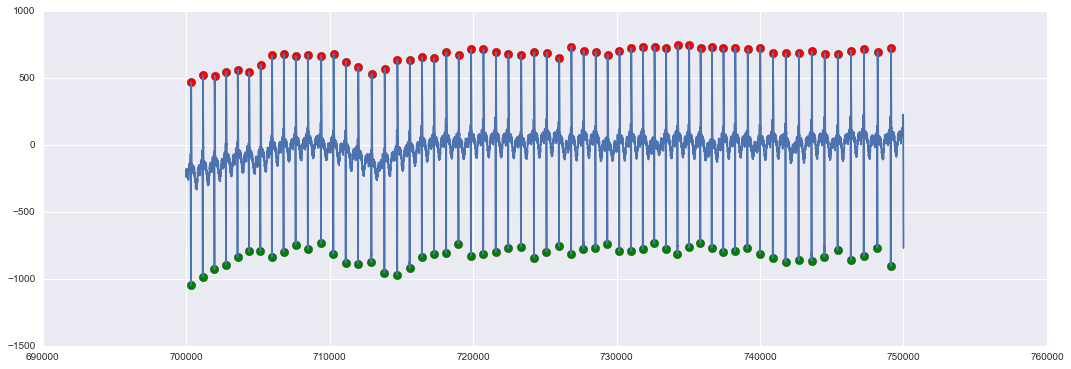

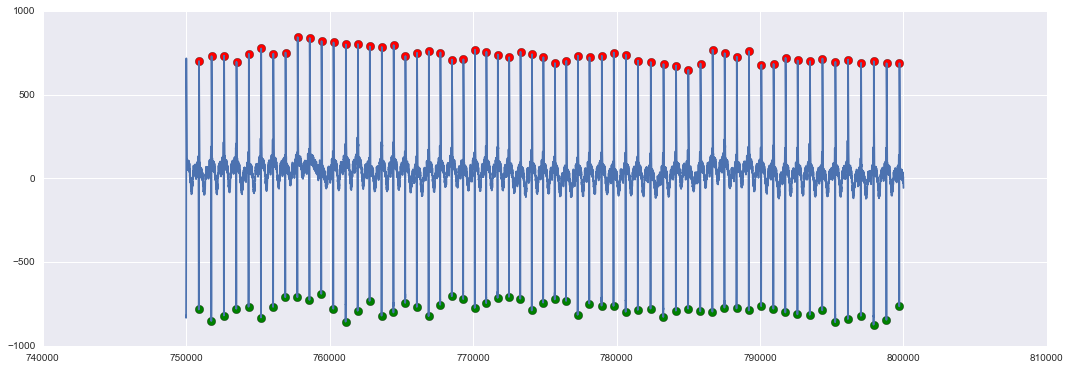

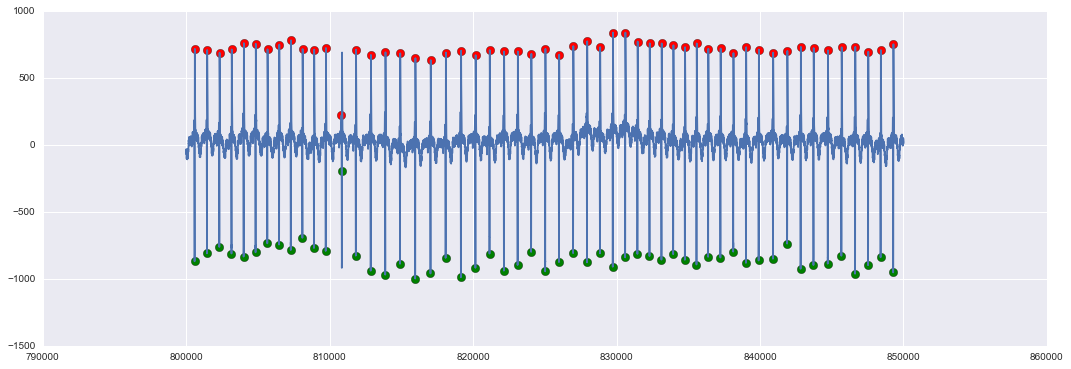

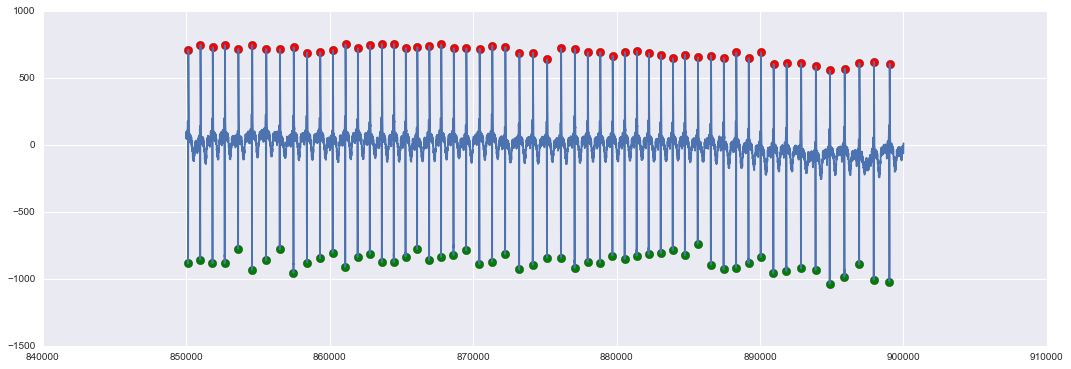

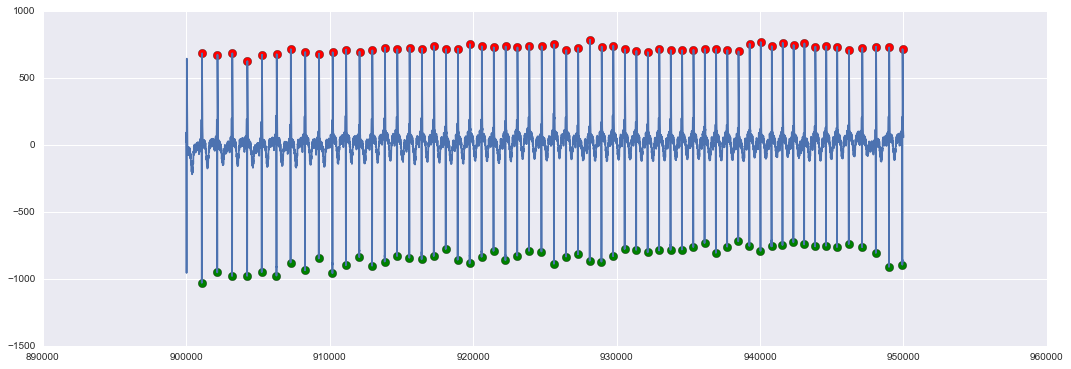

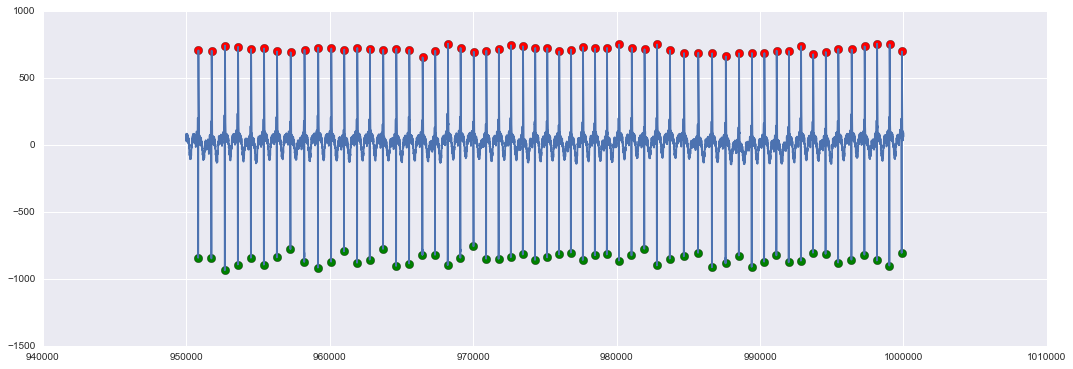

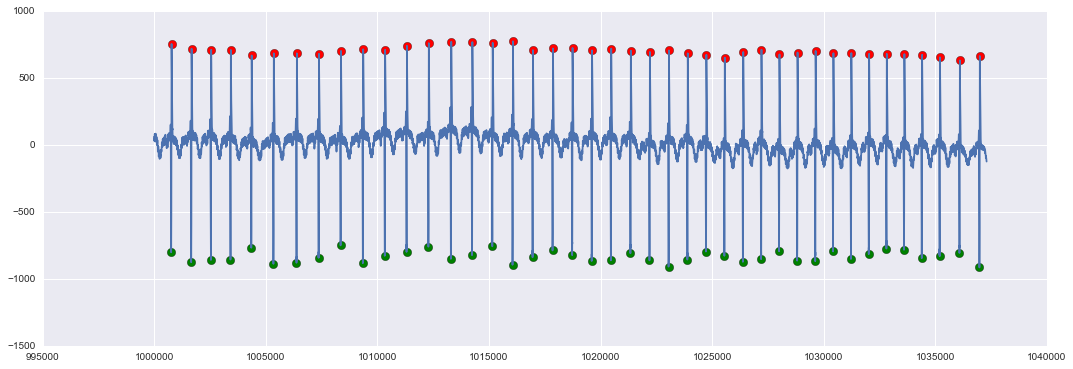

In [235]:
sig = data[1].sig1
window = 50000
offset = 0
roffset=1810000
f = FloatProgress((len(sig)-offset)/window+1)
display(f)
f.value=0
while (offset <= len(sig)) & (offset < roffset):
    drawSignal(sig[offset:min(len(sig), offset+window)])
    offset+=window
    f.value+=1

### FIR-чистка

In [261]:
b = signal.firwin(257, [48, 52], nyq=1000.0)
cleaned_fir_data = [signal.lfilter(b, [1], sig) for sig in data]
i = 0
f = FloatProgress(min=0, max=len(data))
display(f)
rfft_fir_data = []
for d in cleaned_fir_data:
    rfft_fir_data.append(np.abs(rfft(d[0:524288]))/524288)
    i += 1
    f.value = i

### STFT-чистка

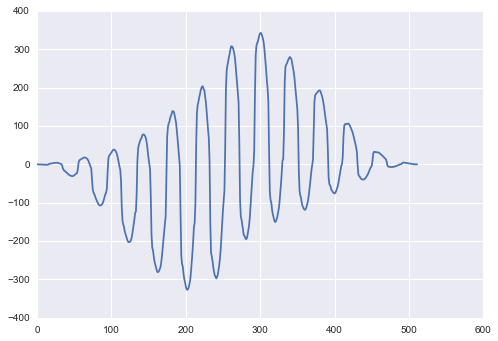

In [27]:
half_cos = np.array([np.cos(2*np.pi*x/512.) + 1 for x in range(-256, 256)])
plt.plot(np.array(data[0][19800:20312])*half_cos)
#plt.plot(half_cos)

In [29]:
cleaned_data = []
rfft_cleaned_data = []
f = FloatProgress(min=0, max=len(data))
display(f)
for d in data:
    cleaned = STFT_children(d)[0]
    rfft_cleaned_data.append(np.abs(rfft(cleaned[0:524288]))/524288)
    cleaned_data.append(cleaned)
    f.value+=1

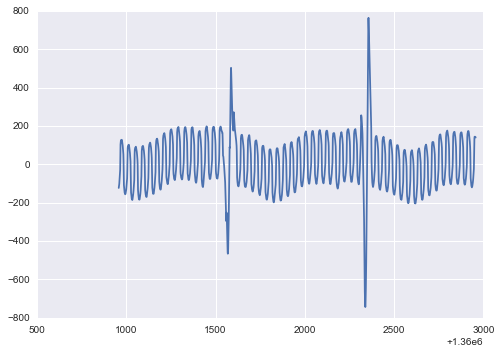

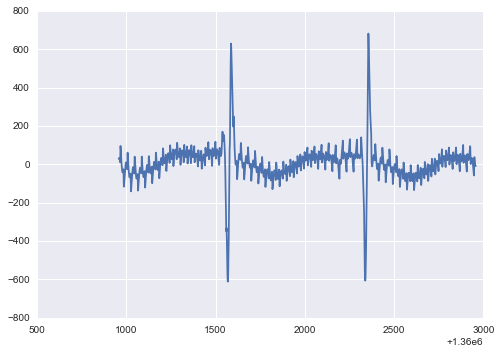

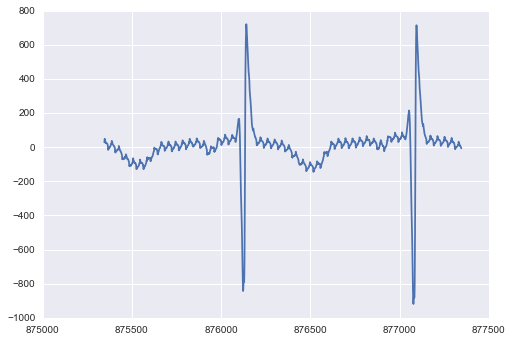

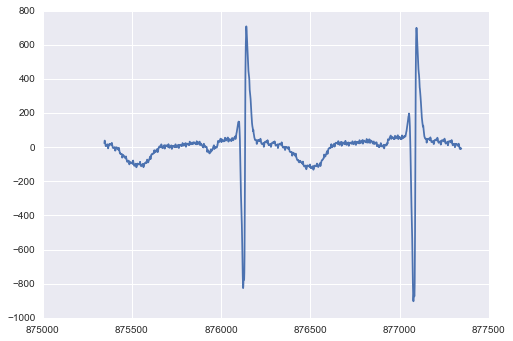

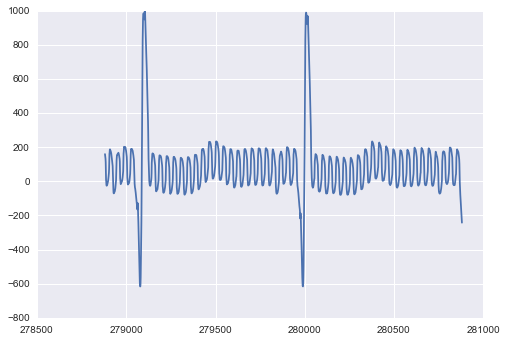

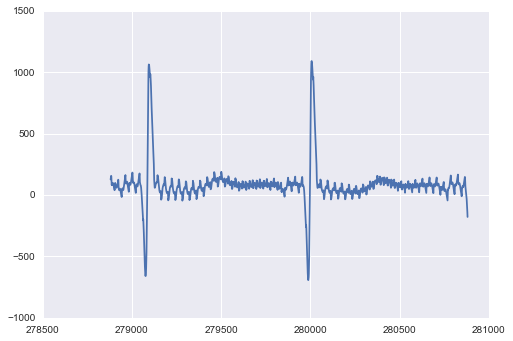

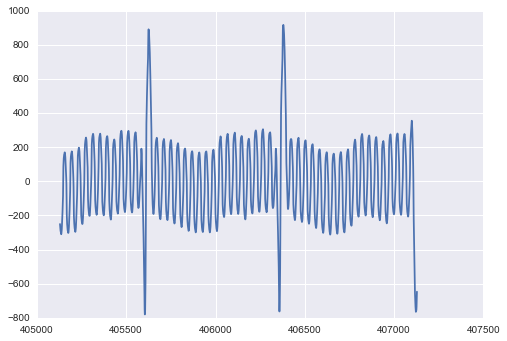

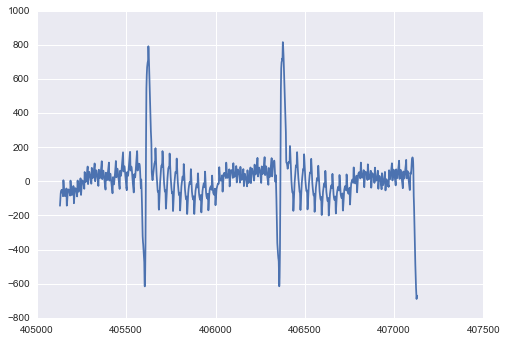

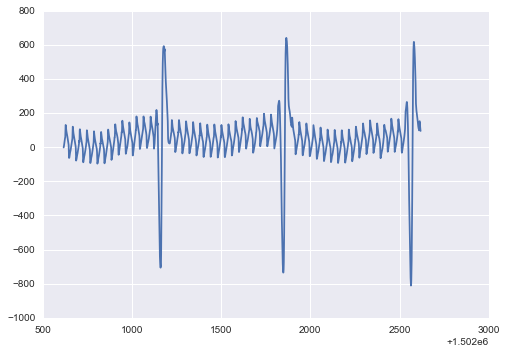

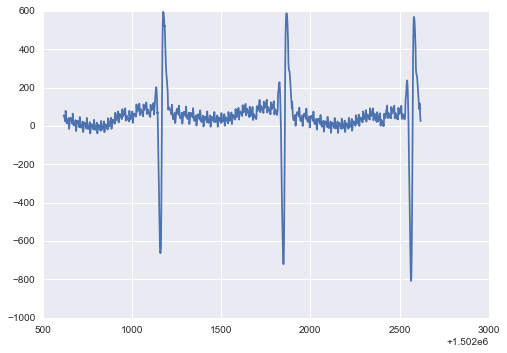

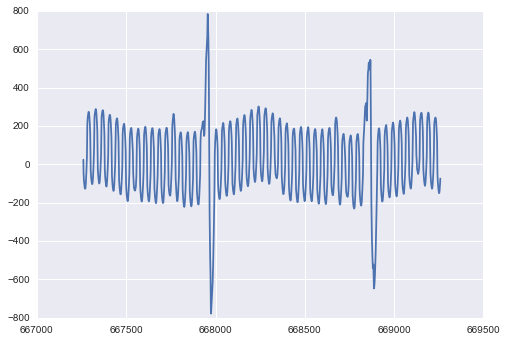

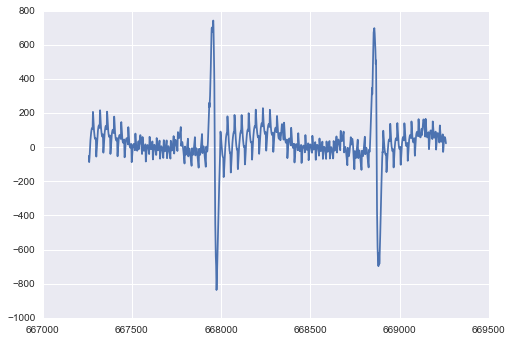

In [33]:
dist = 2000
#plt.figure(figsize=(2*7, 6*8))
for i in range(6):
    #plt.subplot(6, 2, 2*i+1)
    left = np.random.randint(0, len(data[i]) - 2*dist)
    right = left + dist
    plt.figure()
    plt.plot(data[i][left:right])
    #plt.subplot(2, 6, 2*i+2)
    plt.figure()
    plt.plot(cleaned_data[i][left:right])

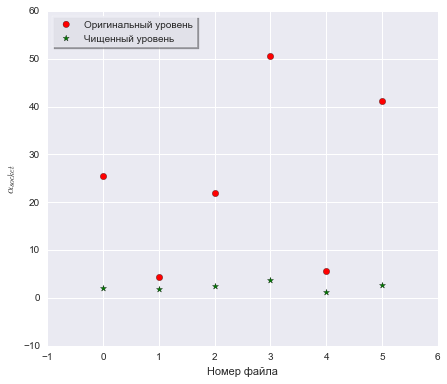

In [34]:
socket_factor_cleaned = []
high_freqs_factor_cleaned = []
for spectre in rfft_cleaned_data:
    a, b = hz(2*len(spectre), FD, 150, 800)
    high_freq_ampl = np.max(spectre[a:b])
    a, b = hz(2*len(spectre), FD, 47, 54)
    sock_ampl = np.max(spectre[a:b])
    a, b = hz(2*len(spectre), FD, 55, 70)
    mean_noise = np.max(spectre[a:b])
    socket_factor_cleaned.append(float(sock_ampl)/mean_noise)
    high_freqs_factor_cleaned.append(float(high_freq_ampl)/mean_noise)
    
socket_factor = []
high_freqs_factor = []
for spectre in rfft_data:
    a, b = hz(2*len(spectre), FD, 150, 800)
    high_freq_ampl = np.max(spectre[a:b])
    a, b = hz(2*len(spectre), FD, 47, 54)
    sock_ampl = np.max(spectre[a:b])
    a, b = hz(2*len(spectre), FD, 55, 70)
    mean_noise = np.max(spectre[a:b])
    socket_factor.append(float(sock_ampl)/mean_noise)
    high_freqs_factor.append(float(high_freq_ampl)/mean_noise)
    
plot = plt.figure(figsize=(7, 6))
plt.scatter(range(len(socket_factor)), socket_factor, c='r', s=40, label=u'Оригинальный уровень')
plt.scatter(range(len(socket_factor)), socket_factor_cleaned, c='g', s=40, label=u'Чищенный уровень', marker='*')
plt.xlabel(u"Номер файла")
plt.ylabel(r"$\alpha_{socket}$")
plt.legend(loc='upper left', frameon=True, shadow=True, framealpha=0.9)

In [10]:
half_cos = np.array([np.cos(2*np.pi*x/512.) + 1 for x in range(-256, 256)])

def STFT_children2(sig, fd=2000, interval=(40, 60), delta=512, border=50):
    from numpy.fft import rfft, rfftfreq
    from sklearn.preprocessing import scale as sc
    
    mid_ampl = []
    mn, mx = getExtremaSuperFast(sig)
    mids = getMids(mx)
    clr_sig = np.array(sig)

    for i in range(len(mids)):
        sig_part = np.array(clr_sig[mids[i]-delta/2 : mids[i]+delta/2])*half_cos
        spectrum = rfft(sig_part)
        a,b = hz(len(sig_part), fd, interval[0], interval[1])
        w = np.argmax(np.abs(spectrum[a:b])) #частота 
        A = spectrum[a+w]/len(sig_part) #амплитутда
        mid_ampl.append(np.abs(2.*A))
        def cos_to_remove(x):
            return (2.)*A*np.exp(2*1j*np.pi*(a+w)*(x)/len(sig_part))

        left = mx[i]-border/2
        left = left if left > 0 else 0
        right = mx[i+1]+border/2
        right = right if right < len(clr_sig) else len(clr_sig)-1
        cos_graph = [cos_to_remove(x) for x in range(-(right-left)/2, (right-left)/2)]
        graph_len = len(cos_graph) -1
        
        scale = border
        for j in range(scale):
            cos_graph[j] *= float(j)/(scale)
            cos_graph[graph_len-j] *= float(j)/(scale)
        
        clr_sig[left:right] += cos_graph
    return pd.Series(clr_sig), np.mean(mid_ampl)

In [13]:
half_cos = np.array([np.cos(2*np.pi*x/512.) + 1 for x in range(-256, 256)])

def STFT_children(sig, fd=2000, interval=(40, 60), delta=512, border=50):
    from numpy.fft import rfft, rfftfreq
    from sklearn.preprocessing import scale as sc
    clr_sig = sig.copy()
    
    mid_ampl = []
    mn, mx = getExtremaSuperFast(clr_sig)
    mids = getMids(mx)
    for i in range(len(mids)):
        sig_part = np.array(clr_sig[mids[i]-delta/2 : mids[i]+delta/2])*half_cos
        spectrum = rfft(sig_part)
        a,b = hz(len(sig_part), fd, interval[0], interval[1])
        w = np.argmax(np.abs(spectrum[a:b])) #частота 
        A = spectrum[a+w]/len(sig_part) #амплитутда
        mid_ampl.append(np.abs(2.*A))
        def cos_to_remove(x):
            return (2.)*A*np.exp(2*1j*np.pi*(a+w)*(x)/len(sig_part))

        left = mx[i]-border/2
        left = left if left > 0 else 0
        right = mx[i+1]+border/2
        right = right if right < len(clr_sig) else len(clr_sig)-1
        cos_graph = [cos_to_remove(x) for x in range(-(right-left)/2, (right-left)/2)]
        graph_len = len(cos_graph) -1
        
        scale = border
        for j in range(scale):
            cos_graph[j] *= float(j)/(scale)
            cos_graph[graph_len-j] *= float(j)/(scale)
        
        clr_sig[left:right] += np.real(cos_graph)
        start_index = clr_sig.index[0]
    return clr_sig, np.mean(mid_ampl)

### Триплеты

In [35]:
lit_before = []
lit_after = []
f = FloatProgress(min=0, max=12)
display(f)
for i in range(6):
    lit_before.append((analyzeLiterals(data[i][:len(data[i])/2])[0], analyzeLiterals(data[i][len(data[i])/2:])[0]))
    f.value+=1
    lit_after.append((analyzeLiterals(cleaned_data[i][:len(data[i])/2])[0], analyzeLiterals(cleaned_data[i][len(data[i])/2:])[0]))
    f.value+=1

In [36]:
print(lit_before[3][1].most_common(15))
print(lit_after[3][1].most_common(15))

[('FCD', 13), ('AFA', 12), ('CDA', 11), ('FAC', 11), ('DCD', 10), ('DAD', 10), ('CFA', 10), ('ACD', 9), ('FCF', 9), ('DFC', 9), ('CDC', 9), ('FAD', 9), ('ADA', 8), ('CDD', 8), ('CDF', 8)]
[('FAF', 49), ('AFA', 41), ('CDC', 30), ('DCD', 29), ('AFC', 26), ('CFA', 22), ('FCD', 21), ('DCF', 20), ('ADC', 20), ('DAD', 18), ('ADA', 17), ('CDA', 16), ('DAF', 14), ('FAD', 14), ('FCF', 13)]


In [44]:
for i in range(6):
    f = open(str(i)+".txt", 'w')
    fgc = np.zeros((2, 216))
    for j in range(2):
        orig, clean = lit_before[i][j], lit_after[i][j]
        for t in range(216):
            fgc[j][t] = clean.get(num_to_trig(t), 0)
    for first, second in zip(fgc[0], fgc[1]):
        f.write(str(int(first)) + " " + str(int(second)) + "\n")
    f.close()

## Стандартные фильтры

In [38]:
b = signal.firwin(301, [45, 55], nyq=1000.0)
cleaned_fir_data = [signal.lfilter(b, [1], sig) for sig in data]
i = 0
f = FloatProgress(min=0, max=len(data))
display(f)
rfft_fir_data = []
for d in cleaned_fir_data:
    rfft_fir_data.append(np.abs(rfft(d[0:524288]))/524288)
    i += 1
    f.value = i

In [39]:
trigrams_fir_data = [analyzeLiterals(pd.Series(f))[0] for f in cleaned_fir_data]

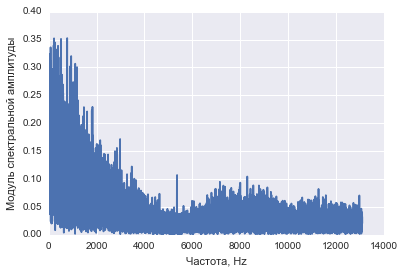

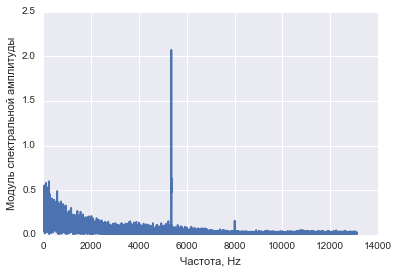

In [555]:
sig = rfft_fir_data[5]
a, b = hz(len(sig)*2, FD, 30, 80)
plt.plot(sig[a:b])
#plt.xticks(range(0, 5243, 1310), range(40, 61, 5))
plt.xlabel(u"Частота, Hz")
plt.ylabel(u"Модуль спектральной амплитуды")
plt.figure()
sig = rfft_data[7]
plt.plot(sig[a:b])
#plt.xticks(range(0, 5243, 1310), range(40, 61, 5))
plt.xlabel(u"Частота, Hz")
plt.ylabel(u"Модуль спектральной амплитуды")

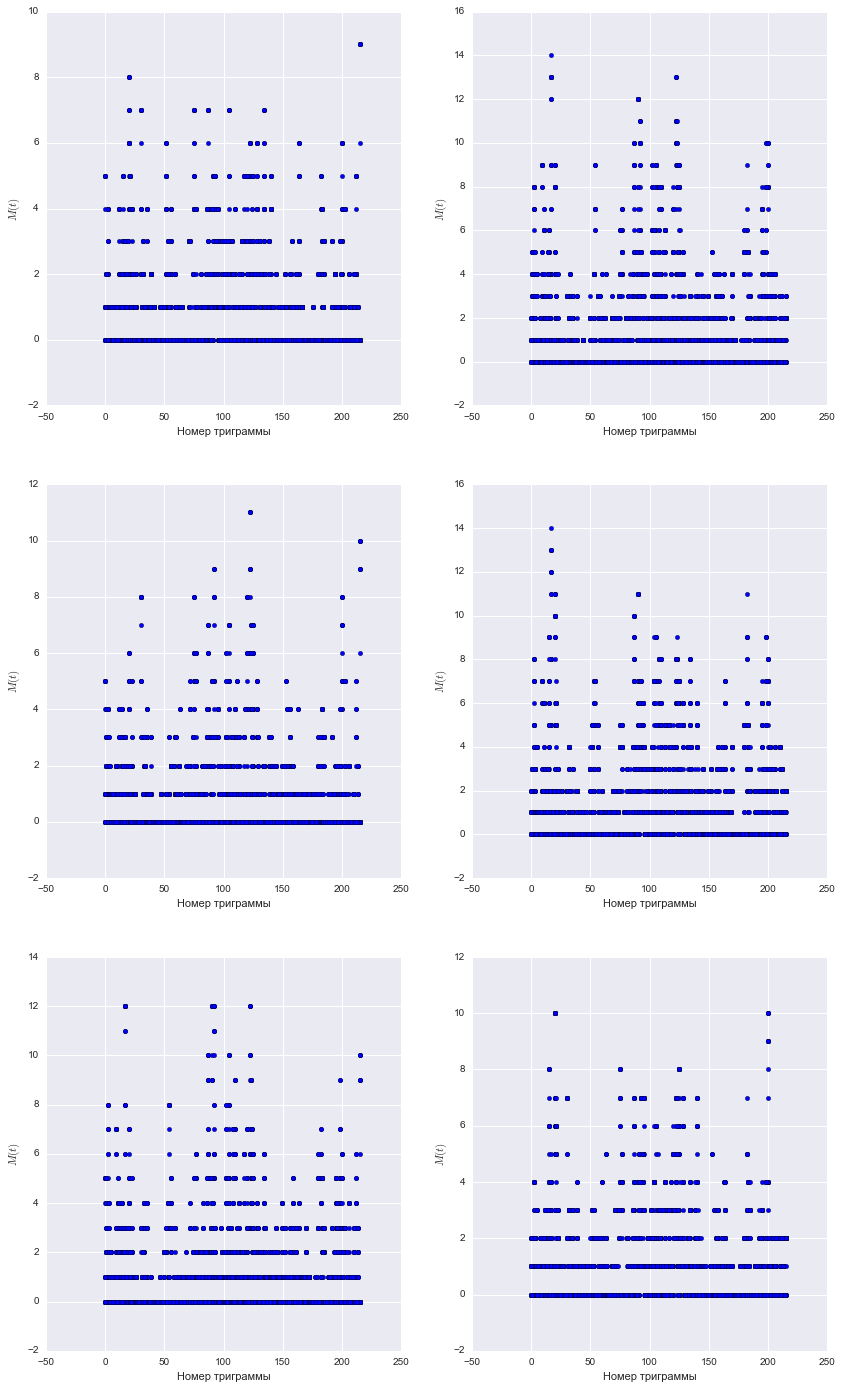

In [63]:
nf = 2
iters = 3
plt.figure(figsize=(nf*7, iters*8))
from sklearn.cross_validation import KFold
for i in range(iters):
    dataset = np.random.choice(28, 28/nf)
    #print(dataset)
    fgc = np.zeros(216)
    for num, (orig, clean) in enumerate(zip(trigrams_data, trigrams_fir_data)):
        if num in dataset and num != 12:
            for key, item in getQuantDisperce2(orig, clean):
                    fgc[key] += np.abs(item)
        plt.subplot(iters, nf, nf*i+1)
        plt.scatter(range(len(fgc)), fgc)
        plt.xlabel(u"Номер триграммы")
        plt.ylabel(r"$M(t)$")
    fgc = np.zeros(216)
    for num, (orig, clean) in enumerate(zip(trigrams_data, trigrams_fir_data)):
        if num not in dataset and num != 12:
            for key, item in getQuantDisperce2(orig, clean):
                    fgc[key] += np.abs(item)
        plt.subplot(iters, nf, nf*i + 2)
        plt.scatter(range(len(fgc)), fgc)
        plt.xlabel(u"Номер триграммы")
        plt.ylabel(r"$M(t)$")

# Зануляющий высокие частоты фильтр

In [52]:
b = signal.firwin(301, [0.01, 150], pass_zero=False, nyq=1000.0)
cleaned_cut_data = [signal.lfilter(b, [1], sig) for sig in data]
i = 0
f = FloatProgress(min=0, max=len(data))
display(f)
rfft_cut_data = []
for d in cleaned_data:
    rfft_cut_data.append(np.abs(rfft(d[0][0:524288]))/524288)
    i += 1
    f.value = i

In [53]:
trigrams_cut_data = [analyzeLiterals(pd.Series(f))[0] for f in cleaned_cut_data]

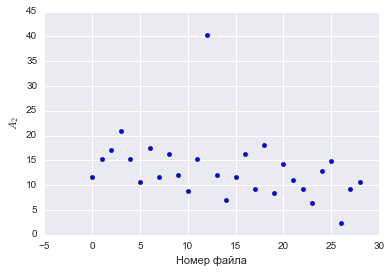

In [58]:
score = np.array([compareTrigramsFreqClass(*t) for t in zip(trigrams_data, trigrams_cut_data)])
plt.scatter(range(len(score)), 100*score)
plt.xlabel(u'Номер файла')
plt.ylabel(r'$A_2$')


# Столбики с частотами

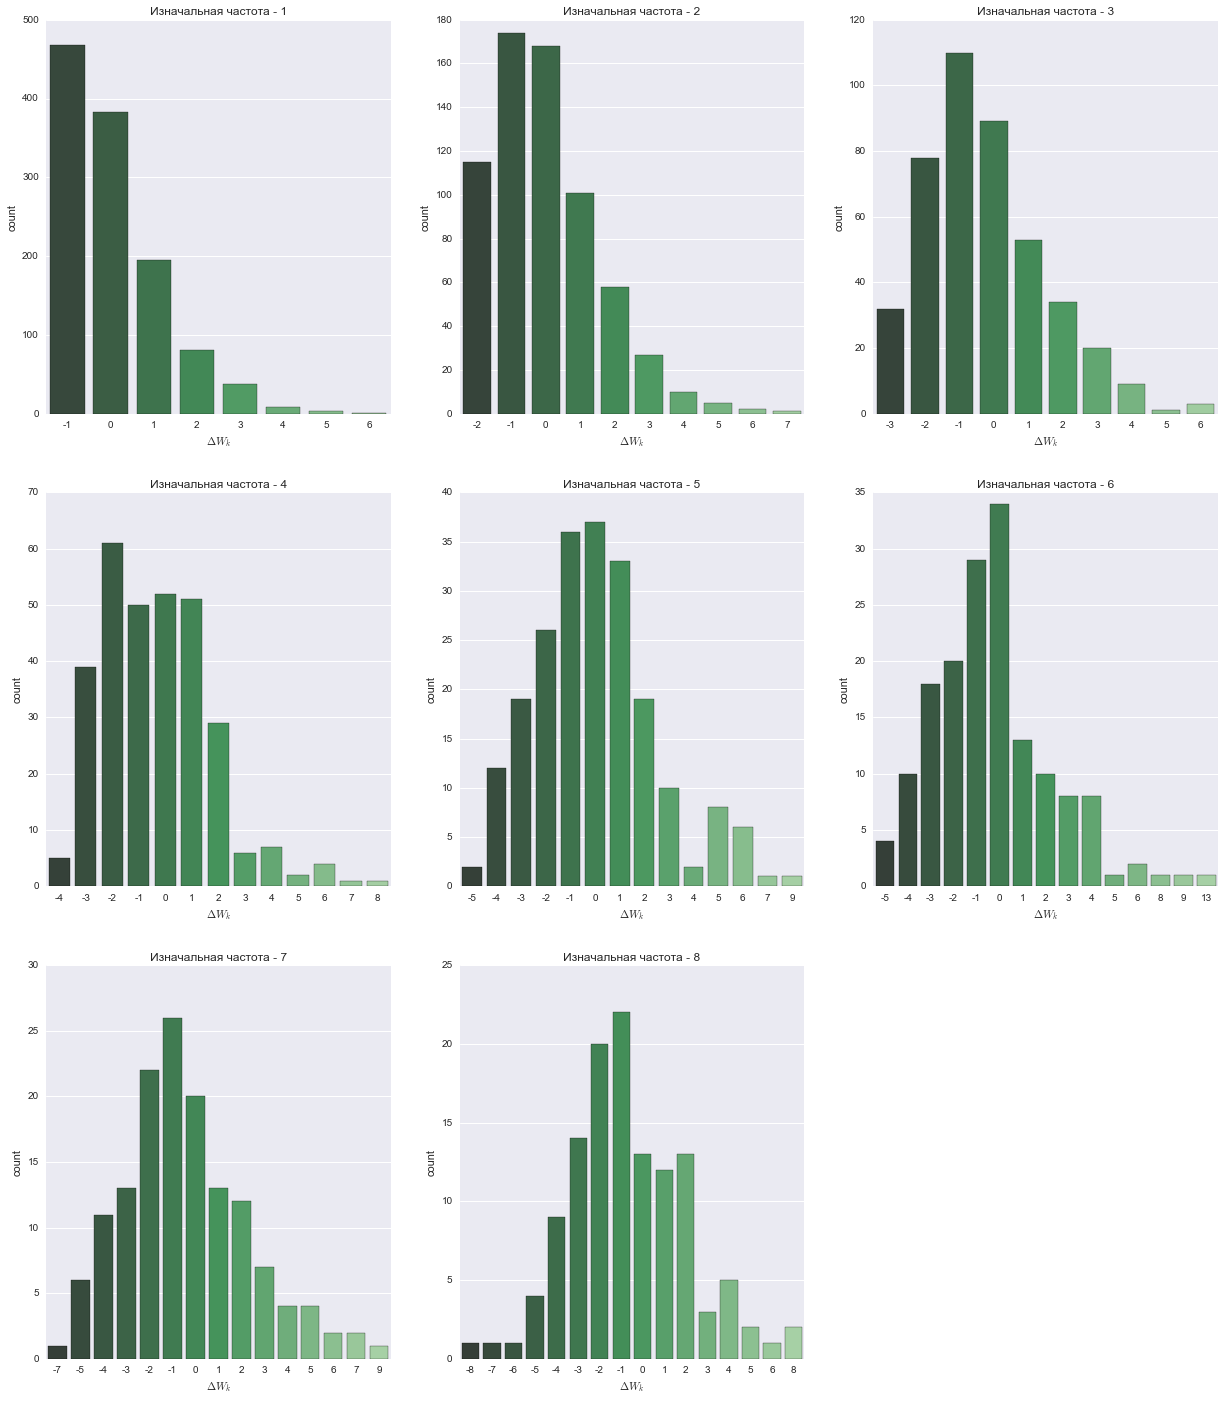

In [42]:
max_freq = 9
plt.figure(figsize=(3*7, 3*8))

ans = []
for i in range(max_freq):
    ans.append([]) 
    
for (orig, cleaned) in zip(trigrams_data, trigrams_cl_data):
    for key, val in orig.items():
        if val < max_freq:
            ans[val].append(cleaned.get(key, 0)-val)

for i in range(1, len(ans)):
    plt.subplot(3, 3, i)
    sns.countplot(ans[i],  palette="Greens_d")
    plt.title(u'Изначальная частота - ' + str(i))
    plt.xlabel(r'$\Delta W_k$')

## Поиск паттернов розетки

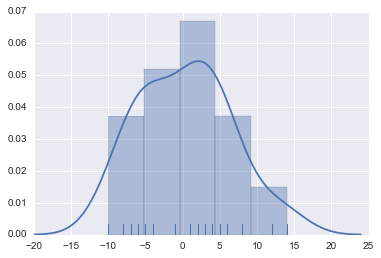

In [332]:
sns.distplot(length[1]-length[0], rug=True)

8 кдмка, 22

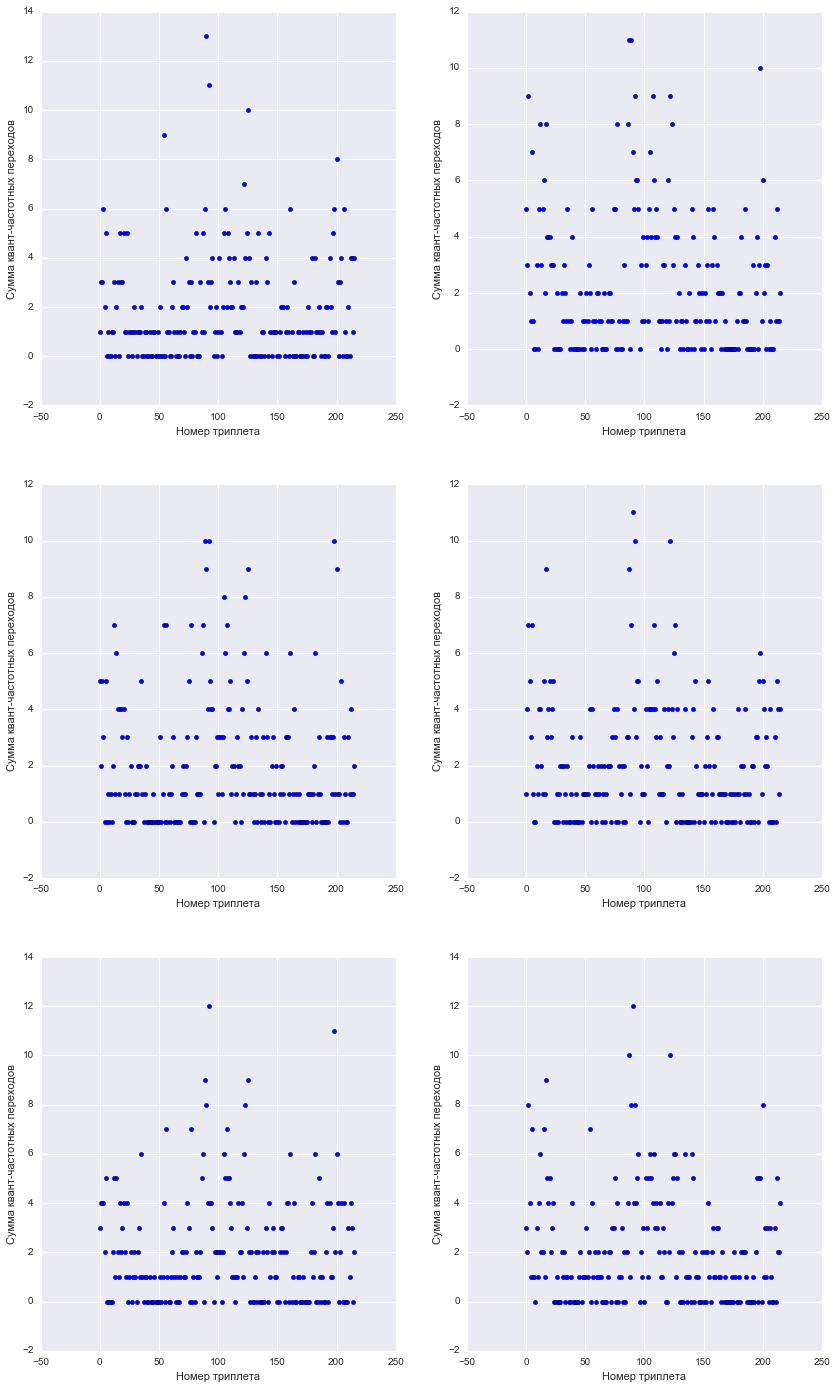

In [62]:



nf = 2
iters = 3
plt.figure(figsize=(nf*7, iters*8))
from sklearn.cross_validation import KFold
for i in range(iters):
    for num, (train, _) in enumerate(KFold(29, n_folds=nf, shuffle=True)):
        fgc = np.zeros(216)
        for tnum, (orig, clean) in enumerate(zip(trigrams_data, trigrams_cl_data)):
            if (tnum in train):
                for key, item in getQuantDisperce2(orig, clean):
                    fgc[key] += np.abs(item)
        
        plt.subplot(iters, nf, nf*i + num+1)
        plt.scatter(range(len(fgc)), fgc)
        plt.xlabel(u"Номер триплета")
        plt.ylabel(u"Сумма квант-частотных переходов")

In [43]:
fir_cnt = Counter()
plt.figure(figsize=(20, 60))
for tnum, (orig, clean) in enumerate(zip(trigrams_data, trigrams_fir_data)):
    loc_cnt = Counter()
    fgc = np.zeros(216)
    for key, item in getQuantDisperce2(orig, clean):
        fgc[key] += item
        loc_cnt[key] += np.abs(item)
    fir_cnt.update(loc_cnt)
    #plt.subplot(10,3, tnum+1)
    #plt.scatter(range(216), fgc)
#cnt.most_common(10)


In [50]:
for (a, b) in zip([num_to_trig(x[0]) for x in cl_cnt.most_common(10)], [num_to_trig(x[0]) for x in fir_cnt.most_common(10)]):
    print a, ' & ', b, '\\'

CDA  &  CAC \
CDC  &  CDC \
CCF  &  ACA \
CCD  &  DCA \
DCC  &  ACD \
FDA  &  DCD \
DCF  &  ACF \
FDC  &  CFD \
ACF  &  DCC \
AAC  &  ADC \


## Эксперимент №1: анализ изменений частот триплетов при наложении шума

In [6]:
file_names = ["kdms/proved/" + str(x) + ".txt" for x in range(0, 29)]
data = [readSignalFromFile(f).sig1 for f in file_names]

In [7]:
i = 0
f = FloatProgress(min=0, max=len(data))
display(f)
cleaned_data = []
for d in data:
    cleaned_data.append(deSocketFull(d))
    i += 1
    f.value = i

In [181]:
i = 0
f = FloatProgress(min=0, max=len(data))
mid_ampl_of_noise = []
display(f)
for d in data:
    mid_ampl_of_noise.append(deSocketFull(d)[1])
    i += 1
    f.value = i

In [184]:
mean_deltas_in_cleaned_signal = [np.mean(analyzeLiterals(d[0])[2]) for d in cleaned_data]

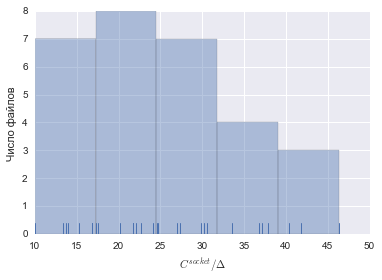

In [226]:
sns.distplot(100.*mid_ampl_of_noise/mean_deltas_in_cleaned_signal, kde=False, rug=True)
plt.xlabel(r"$C^{socket}/\Delta$")
plt.ylabel(u"Число файлов")

In [19]:
len(cleaned_data[0][0])

840841

In [20]:
i = 0
f = FloatProgress(min=0, max=len(data))
display(f)
rfft_cleaned_data = []
for d in cleaned_data:
    rfft_cleaned_data.append(np.abs(rfft(d[0][0:524288]))/524288)
    i += 1
    f.value = i

In [59]:
socket_factor_cleaned = []
high_freqs_factor_cleaned = []
for spectre in rfft_fir_data:
    a, b = hz(2*len(spectre), FD, 150, 800)
    high_freq_ampl = np.max(spectre[a:b])
    a, b = hz(2*len(spectre), FD, 47, 54)
    sock_ampl = np.max(spectre[a:b])
    a, b = hz(2*len(spectre), FD, 55, 70)
    mean_noise = np.max(spectre[a:b])
    socket_factor_cleaned.append(float(sock_ampl)/mean_noise)
    high_freqs_factor_cleaned.append(float(high_freq_ampl)/mean_noise)

In [22]:
socket_factor = []
high_freqs_factor = []
for spectre in rfft_data:
    a, b = hz(2*len(spectre), FD, 150, 800)
    high_freq_ampl = np.max(spectre[a:b])
    a, b = hz(2*len(spectre), FD, 47, 54)
    sock_ampl = np.max(spectre[a:b])
    a, b = hz(2*len(spectre), FD, 55, 70)
    mean_noise = np.max(spectre[a:b])
    socket_factor.append(float(sock_ampl)/mean_noise)
    high_freqs_factor.append(float(high_freq_ampl)/mean_noise)

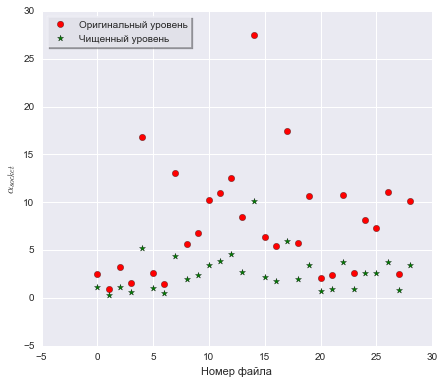

In [60]:
plot = plt.figure(figsize=(7, 6))
plt.scatter(range(len(socket_factor)), socket_factor, c='r', s=40, label=u'Оригинальный уровень')
plt.scatter(range(len(socket_factor)), socket_factor_cleaned, c='g', s=40, label=u'Чищенный уровень', marker='*')
plt.xlabel(u"Номер файла")
plt.ylabel(r"$\alpha_{socket}$")
plt.legend(loc='upper left', frameon=True, shadow=True, framealpha=0.9)

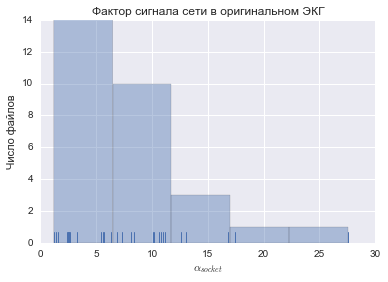

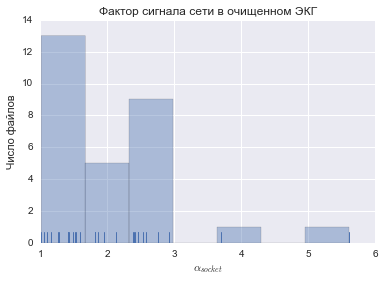

In [225]:
sns.distplot(socket_factor, kde=False, rug=True)
plt.title(u"Фактор сигнала сети в оригинальном ЭКГ")
plt.xlabel(r"$\alpha_{socket}$")
plt.ylabel(u"Число файлов")
plt.figure()
sns.distplot(socket_factor_cleaned, kde=False, rug=True)
plt.title(u"Фактор сигнала сети в очищенном ЭКГ")
plt.xlabel(r"$\alpha_{socket}$")
plt.ylabel(u"Число файлов")

In [8]:
trigrams_cl_data = []
trigrams_cl_data = [analyzeLiterals(f[0])[0] for f in cleaned_data]

In [9]:
trigrams_data = []
trigrams_data = [analyzeLiterals(f)[0] for f in data]

17, 26

In [259]:
euc_error_after_clean = []
freq_error_after_clean = []
for a, b in zip(trigrams_data, trigrams_cl_data):
    euc_error_after_clean.append(compareTrigramsEuc(a, b, treshold=0))
    freq_error_after_clean.append(compareTrigramsFreqClass(a, b, threshold=15))
euc_error_after_clean = np.array(euc_error_after_clean)
freq_error_after_clean = np.array(freq_error_after_clean)


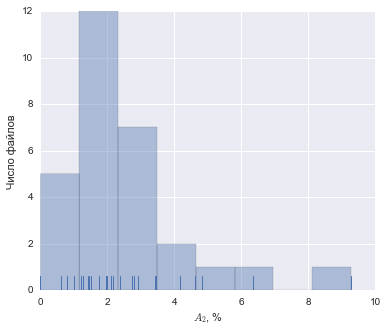

In [260]:
plt.figure(figsize=(6, 5))
sns.distplot(freq_error_after_clean*100, kde=False, rug=True)
plt.xlabel(r"$A_2$, %")
plt.ylabel(u"Число файлов")

In [80]:
pickle.dump(cleaned_errors, open('cleaned_errors_wo_17_26.dump', 'w'))

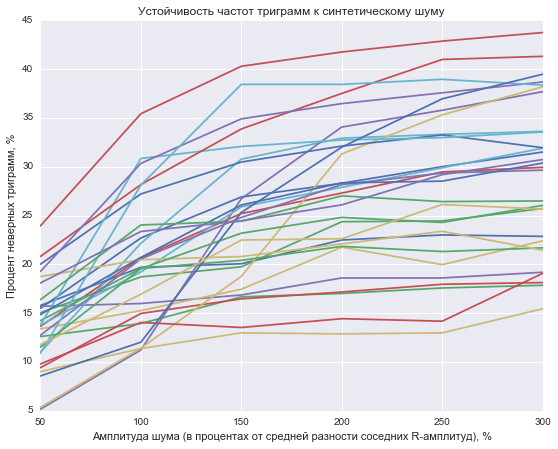

In [159]:
plt.figure(figsize=(9, 7))
file_num = 0
for test_file in cleaned_errors:
    test_file = test_file[0]
    original_trigram = test_file[0][0]
    ampl_error = []
    for ampl in test_file[1:]:
        loc_error = []
        for trigram in ampl:
            loc_error.append(compareTrigramsEuc(original_trigram, trigram, treshold=0.3))
        ampl_error.append(np.mean(loc_error))
    plt.plot(np.array(ampl_error)*100)
    file_num+=1
    
plt.xticks(np.arange(0, 6), np.arange(50,310, 50))
plt.xlabel(u"Амплитуда шума (в процентах от средней разности соседних R-амплитуд), %")
plt.ylabel(u"Процент неверных триграмм, %")
plt.title(u"Устойчивость частот триграмм к синтетическому шуму")

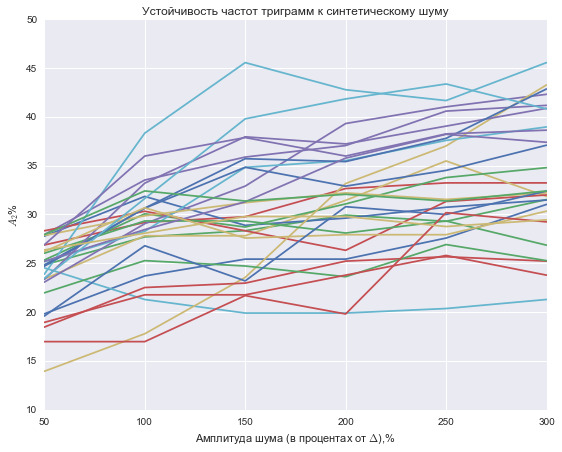

In [231]:
plt.figure(figsize=(9, 7))
file_num = 0
for test_file in cleaned_errors:
    test_file = test_file[0]
    original_trigram = trigrams_cl_data[file_num]
    ampl_error = []
    for ampl in test_file[1:]:
        loc_error = []
        for trigram in ampl:
            loc_error.append(compareTrigramsFreqClass(original_trigram, trigram, threshold=2))
        ampl_error.append(np.mean(loc_error))
    plt.plot(np.array(ampl_error)*100)
    file_num+=1
    
plt.xticks(np.arange(0, 6), np.arange(50,310, 50))
plt.xlabel(u"Амплитуда шума (в процентах от " + r"$\Delta$" + "),%")
plt.ylabel(u"$A_2$%")
plt.title(u"Устойчивость частот триграмм к синтетическому шуму")

## Тест алгоритмов на новых КДМках

In [17]:
def variate(fig, ampl_steps=7, phase_steps=2):    
    codograms, _, deltas = analyzeLiterals(fig)
    ampl = 3*np.mean(deltas)
    a,b = hz(512, 2000, 50.45, 60)

    f = FloatProgress(min=0, max=ampl_steps)
    display(f)

    i=1
    errors = []
    for alpha in np.linspace(0, ampl, ampl_steps):    
        loc_errors = []
        for shift in range(0, 60, 60/phase_steps):
            noise = [noiseSin(x, a, alpha, shift) for x in range(len(fig))]
            res = fig - np.real(noise)
            new_codograms, _ , _ = analyzeLiterals(res)
            loc_errors.append(new_codograms)
            #loc_errors.append(compareCodogramsEuc(codograms, new_codograms))
        errors.append(loc_errors)
        f.value = i
        i+=1
    return errors, ampl

def compareTrigramsEuc(a, b, trigrams_to_analyze = None, treshold=0.1):
    if (trigrams_to_analyze == None):
        trigrams_to_analyze = []
        max_freq = np.max(a.values())
        for t in a.items():
            if (t[1] > treshold*max_freq):
                trigrams_to_analyze.append(t[0])
    resulted_error = 0
    total_points = 0
    for c in trigrams_to_analyze:
        resulted_error += np.abs((a.get(c, 0) - b.get(c, 0)))
        total_points += a.get(c, 0)
    return float(resulted_error)/(2*total_points);

def compareTrigramsFreqClass(a, b, threshold=2):
    trigrams_to_analyze = []
    for t in a.items():
        trigrams_to_analyze.append(t[0])
    
    total_points = 0
    for c in trigrams_to_analyze:
        if ((a.get(c, 0) >= threshold) ^ (b.get(c, 0) >= threshold)):
            total_points += 1
    return float(total_points)/216

# Инструментарий: используемые функции

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from numpy.fft import fft, rfft, rfftfreq, irfft

def getQuantDisperce2(a, b, quant_size = 3):
    ans = []
    c = b.copy()
    c.subtract(a)
    for key, w in c.items():
        ans.append((trig_to_num(key), np.sign(w)*(np.abs(w)//quant_size)))
    return ans

def noiseSin(x, a, ampl, shift):
    return ampl*np.exp(2*1j*np.pi*(a)*(x-shift)/512)

def drawSignal(sig, with_min=True, with_max=True, extrema=None, fig_size=(18,6)):
    plt.figure(figsize=fig_size)
    plt.plot(sig)
    if (with_min | with_max):
        mn, mx = getExtremaSuperFast(sig) if extrema == None else extrema
        #mn, mx = getExtrema(sig) if extrema == None else extrema
        if (with_max):
            plt.scatter(mx, [sig[x] for x in mx], c='r', s=70)
        if (with_min):
            plt.scatter(mn, [sig[x] for x in mn], c='g', s=70)
        return len (mn)

def readSignalFromFile(file_name):
    splitted = [s.split() for s in open(file_name, 'r').readlines()]
    return pd.DataFrame(splitted, columns=['sig1', 'sig2']).astype(float)

def getDefaultPeak():
    import pickle
    return pickle.load(open('patterns/default_QRS.dump', 'r'))

def getExtrema(signal, peak_criterion=0.7, epsilon=10, model=None):
    from sklearn.preprocessing import scale
    
    if (model == None):
        model = getDefaultPeak() 
        
    epsilon = len(model)
    scaled = scale(model, with_std=False)
    ideal_max = np.argmax(scaled)
    ideal_min = np.argmin(scaled)
    
    win_len = len(model)
    corr = []
    for i in range(0, len(signal) - win_len):
        win = signal[i:i+win_len]
        corr.append(np.correlate(scaled, scale(win, with_std = False)))

    m = max(corr)
    peaks = np.array([x if x > m*peak_criterion else 0 for x in corr]);
    
    from scipy.signal import argrelextrema
    max_peak_points = argrelextrema(peaks, np.greater) + ideal_max
    min_peak_points = argrelextrema(peaks, np.greater) + ideal_min
    
    def left(x):
        return x-epsilon if (x-epsilon >= 0) else 0
    def right(x):
        return x+epsilon #if (x+epsilon <= len(signal)) else len(signal)
    
    real_max_peak_points = [np.argmax(signal[left(x) : right(x)]) - signal.first_valid_index() for x in max_peak_points[0]]
    real_min_peak_points = [np.argmin(signal[left(x) : right(x)]) - signal.first_valid_index() for x in min_peak_points[0]]
    
    #real_max_peak_points = [np.argmax(signal[x-epsilon : x+epsilon]) for x in max_peak_points[0]]
    #real_min_peak_points = [np.argmin(signal[x-epsilon : x+epsilon]) for x in min_peak_points[0]]
    
    return real_min_peak_points, real_max_peak_points

def analyzeLiterals(s, extrema = None):
    if (extrema == None):
        mn, mx = getExtremaSuperFast(s)
    else:
        mn, mx = extrema
    periods = []
    delta_periods = []
    amplitudes = []#[s[mx[0]] - s[mn[0]]]
    delta_amplitudes = []
    angles = []
    delta_angles = []
    abs_deltas = []
    for i in range(len(mx)-1):
        p = mx[i+1]-mx[i]
        periods.append(np.abs(p))
        am = np.abs(s[mx[i]] - s[mn[i]])
        amplitudes.append(am)
        angles.append(float(am)/p)
        if (i >= 1):
            delta_periods.append((periods[i] - periods[i-1])>=0)
            delta_amplitudes.append((amplitudes[i]-amplitudes[i-1])>=0)
            abs_deltas.append(np.abs(amplitudes[i]-amplitudes[i-1]))
            delta_angles.append((angles[i]-angles[i-1])>=0)
    deltas = zip(delta_amplitudes, delta_periods, delta_angles)
    
    for i in range(len(deltas)):
        if ((deltas[i] == (True, False, False)) | (deltas[i]==(False, True, True))):
            print deltas[i]
            print amplitudes[i-1], amplitudes[i]
            print periods[i-1], periods[i]
            print angles[i-1], angles[i]
    
    liters_dict = {
        (True, True, True) : "A",
        (False, False, True) : "B",
        (True, False, True) : "C",
        (False, True, False) : "D",
        (True, True, False) : "E",
        (False, False, False) : "F"
    }

    literals = [liters_dict[c] for c in deltas]
    
    from collections import Counter
    codograms = Counter()
    for i in range(len(literals)-3):
        win = literals[i:i+3]
        code = ''.join(win)
        codograms[code] += 1
        
    return codograms, literals, abs_deltas

def getMids(points):
    prev= points[0]
    mids = []
    for i in points[1:]:
        center = (i + prev)/2
        mids.append(center)
        prev = i
    return mids

# функция для перевода герцевого диапазона в числовой. Делает то же самое, что rfftfreq, но для двух точек.
def hz(N, d, a, b):
    return int((N)*float(a)/(d)), int((N)*float(b)/(d))

def trig_to_num(trigram):
    t = {
        'A' : 0,
        'B' : 1,
        'C' : 2,
        'D' : 3,
        'E' : 4,
        'F' : 5
    }
    return 36*t.get(trigram[0]) + 6*t.get(trigram[1]) + t.get(trigram[2])


def num_to_trig(num):
    t = {
        0 : 'A',
        1 : 'B',
        2 : 'C',
        3 : 'D',
        4 : 'E',
        5 : 'F'
    }
    first = t.get(num % 6)
    second = t.get((num//6)%6)
    third = t.get(((num//6)//6)%6)
    return third + second + first

def deSocket(sig, fd, interval=(40, 60)):
    from numpy.fft import rfft, rfftfreq
    
    #mn, mx = getExtrema(sig, model)
    
    spectrum = rfft(sig)
    x_axis = rfftfreq(len(sig), 1./fd)
    a,b = hz(len(sig), fd, interval[0], interval[1])
    w = np.argmax(np.abs(spectrum[a:b])) #частота 
    A = spectrum[a+w]/len(sig) #амплитутда
    
    def cos_to_remove(x):
        return (2.)*A*np.exp(2*1j*np.pi*(a+w)*(x-len(sig)/2)/len(sig))

    cos_graph = [cos_to_remove(x) for x in range(len(sig))]
    return cos_graph + sig


def deSocketFull(sig, fd=2000, interval=(40, 60), delta=256, border=50):
    from numpy.fft import rfft, rfftfreq
    from sklearn.preprocessing import scale as sc
    clr_sig = sig.copy()
    
    mid_ampl = []
    mn, mx = getExtremaSuperFast(clr_sig)
    mids1 = getMids(mx)
    mx1 = sorted(np.concatenate([mids1, mx]))
    mids = getMids(mx1)
    for i in range(len(mids)):
        sig_part = clr_sig[mids[i]-delta/2 : mids[i]+delta/2]
        spectrum = rfft(sig_part)
        x_axis = rfftfreq(len(sig_part), 1./fd)
        a,b = hz(len(sig_part), fd, interval[0], interval[1])
        w = np.argmax(np.abs(spectrum[a:b])) #частота 
        #w = 0
        A = spectrum[a+w]/len(sig_part) #амплитутда
        #A = max(spectrum[a:b])/len(sig_part) #амплитутда
        mid_ampl.append(np.abs(2.*A))
        def cos_to_remove(x):
            return (2.)*A*np.exp(2*1j*np.pi*(a+w)*(x)/len(sig_part))

        left = mids[i]-delta/2-200
        left = left if left > 0 else 0
        right = mids[i]+delta/2+200
        right = right if right < len(clr_sig) else len(clr_sig)-1
        #cos_graph = [cos_to_remove(x) for x in range(len(sig[mx[i]:mx[i+1]]) + 2*border)]
        cos_graph = [cos_to_remove(x) for x in range(-(right-left)/2, (right-left)/2)]
        #plt.figure()
        #plt.plot(sc(sig_part.values, with_std=False), c='r')
        #plt.plot(cos_graph, c='g')
        #plt.figure()
        #plt.plot(spectrum[a:b])
        #plt.scatter([w], spectrum[a+w])
        graph_len = len(cos_graph) -1
        
        scale = border
        for j in range(scale):
            cos_graph[j] *= float(j)/(scale)
            cos_graph[graph_len-j] *= float(j)/(scale)
        #print left, right
        
        clr_sig[left:right] += np.real(cos_graph)
        start_index = clr_sig.index[0]
    return clr_sig, np.mean(mid_ampl)

def getExtremaSuperFast(signal2, scan_area = 600, sdf_area = 4000, abs_indexes=False, min_max_dist=300, max_preferable = False, min_dist_between_extr=600):
    from sklearn.preprocessing import scale
    mn, mx = getExtrema(signal2[:min([sdf_area, len(signal2)])])
    signal = signal2.values
    
    delta_max = []
    for i in range(1, len(mx)):
        delta_max.append(mx[i] - mx[i-1])
    
    delta_min = []
    for i in range(1, len(mn)):
        delta_min.append(mn[i] - mn[i-1])
        
    mean_delta_max = int(np.mean(delta_max))
    mean_delta_min = int(np.mean(delta_min))
    
    max_center =  mx[-1] + mean_delta_max
    min_center =  mn[-1] + mean_delta_min
    while ((max_center < len(signal)) & (min_center < len(signal))):
        current_max = max_center - scan_area/2 + np.argmax(scale(signal[max_center - scan_area/2 : max_center + scan_area/2], with_std = False))
        current_min = min_center - scan_area/2 + np.argmin(scale(signal[min_center - scan_area/2 : min_center + scan_area/2], with_std = False))
        if (np.abs(current_min - current_max) > min_max_dist):
            if (max_preferable):
                current_min = current_max#np.argmin(signal[current_max-min_max_dist:current_max+min_max_dist])
            else:
                current_max = current_min#np.argmax(signal[current_min-min_max_dist:current_min+min_max_dist])
        if (current_max - mx[-1] <= min_dist_between_extr):
            current_max += int(np.mean(delta_max))
        if (current_min - mn[-1] <= min_dist_between_extr):
            current_min += int(np.mean(delta_min))
        
        #current_max = int(current_max)
        #current_min = int(current_min)
                                
        delta_max = delta_max[1:]
        delta_max.append(current_max - mx[-1])
        delta_min = delta_min[1:]
        delta_min.append(current_min - mn[-1])
        #mean_delta_max = int(np.mean([mean_delta_max, current_max - mx[-1]]))
        #mean_delta_min = int(np.mean([mean_delta_min, current_min - mn[-1]]))
        mx.append(current_max)
        mn.append(current_min)
        max_center = current_max + int(np.mean(delta_max))
        min_center = current_min + int(np.mean(delta_min))
        #max_center =  current_max + mean_delta_max
        #min_center =  current_min + mean_delta_min
    
    
    mx = [i + signal2.index[0] for i in mx]
    mn = [i + signal2.index[0] for i in mn]
    return mn, mx

def withPB(func, arr):
    i = 0
    f = FloatProgress(min=0, max=len(arr))
    display(f)
    new_arr = []
    for p in arr:
        new_arr.append(func(p))
        i+=1
        f.value = i
    return new_arr